For this model, we will only be using played_hours as the sole predictors and will be including players with 0 played_hours in order to see how including players with no played hours will affect the model's accuracy. Bsefore we start with building the model, we have to look at the number of players for each player skill level as if there is a class imbalance (Ex. more amateurs than pros), nearest neighbors will be biased (classify amateurs more since there are less pros).  

In order to look at the number of players for each skill level, we decided to create a bar graph with the number of players on the x axis and skill level on the y axis.

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

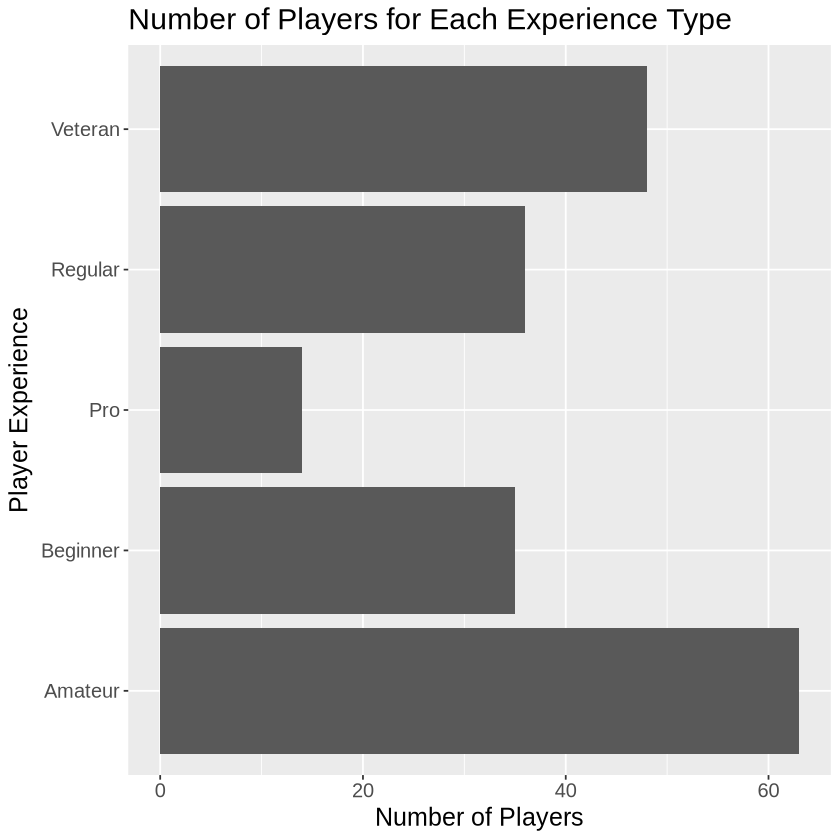

In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
library(themis)
library(yardstick)

players <- read_csv("https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz")
#players
ggplot(players, aes(y = experience)) +
geom_bar(stat = "count") +
labs(x = "Number of Players", y = "Player Experience", title = "Number of Players for Each Experience Type") +
theme(text = element_text(size = 15))

In [13]:
set.seed(3456)
players <- players |> 
mutate(experience = as.factor(experience))

hours0_split <- initial_split(players, prop = 0.75, strata = experience)
hours0_train <- training(hours0_split)
hours0_test <- testing(hours0_split)

summary(hours0_train$experience)

hours0_train <- recipe(experience ~ played_hours, data = hours0_train) |>
step_upsample(experience, over_ratio = 1, skip = FALSE) |>
prep() |>
bake(hours0_train)
summary(hours0_train$experience)

Amateur Beginner      Pro  Regular  Veteran 
      47       25       10       27       37

Amateur Beginner      Pro  Regular  Veteran 
      47       47       47       47       47

In [14]:
set.seed(3456)
hours0_vfold <- vfold_cv(hours0_train, v = 5, strata = experience)

hours0_recipe <- recipe(experience ~ played_hours, data = hours0_train) 

hours0_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
set_engine("kknn") |>
set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 11, by = 1))

hours0_results <- workflow() |>
  add_recipe(hours0_recipe) |>
  add_model(hours0_tune) |>
  tune_grid(resamples = hours0_vfold, grid = k_vals) |>
  collect_metrics() |>
  filter(.metric == "accuracy")
hours0_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.2920000,5,0.02442019,Preprocessor1_Model01
2,accuracy,multiclass,0.3213333,5,0.02612033,Preprocessor1_Model02
3,accuracy,multiclass,0.2893333,5,0.01695892,Preprocessor1_Model03
4,accuracy,multiclass,0.2968889,5,0.02004440,Preprocessor1_Model04
5,accuracy,multiclass,0.3053333,5,0.01611073,Preprocessor1_Model05
6,accuracy,multiclass,0.2915556,5,0.02459951,Preprocessor1_Model06
7,accuracy,multiclass,0.2746667,5,0.02698514,Preprocessor1_Model07
8,accuracy,multiclass,0.2457778,5,0.02472166,Preprocessor1_Model08
9,accuracy,multiclass,0.2506667,5,0.01928858,Preprocessor1_Model09


In [15]:
set.seed(3456)

hours0_model <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
set_engine("kknn") |>
set_mode("classification")

hours0_predict <- workflow() |>
  add_recipe(hours0_recipe) |>
  add_model(hours0_model) |>
  fit(data = hours0_train) |>
  predict(hours0_test) |>
  bind_cols(hours0_test)
                                 
hours0_accuracy <- hours0_predict |>
     metrics(truth = experience, estimate = .pred_class) |>
     filter(.metric == "accuracy")
hours0_accuracy

hours0_precision <- hours0_predict |>
    precision(truth = experience, estimate = .pred_class, event_level="first")
hours0_precision

hours0_recall <- hours0_predict |>
    recall(truth = experience, estimate = .pred_class, event_level="first")
hours0_recall

hours0_matrix <- hours0_predict |>
    conf_mat(truth = experience, estimate = .pred_class)
hours0_matrix

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.24


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,macro,0.09945946


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,macro,0.1597222


          Truth
Prediction Amateur Beginner Pro Regular Veteran
  Amateur       11        6   3       7      10
  Beginner       2        0   0       0       0
  Pro            1        2   0       1       1
  Regular        1        2   1       1       0
  Veteran        1        0   0       0       0

**Analysis**

From the matrix, it looks like the model was unable to correctly classify any beginners or pros correctly which may be due to how pros and beginners have the least amount of players in the dataset which means that the model did not have enough data to train and properly identify pros and beginners in the training dataset even if the data was upsampled. This is due to the fact that upsampling creates new points based on the given data point which means most of the points given in the training dataset would have nearly identical played hours while the points in the testing dataset may have very different played hours due to unlucky splitting of data and the lack of pros and beginners in the original dataset. 

One could argue that we should not upsample the dataset but the main reason why upsampling is necesarry is due to how every type of player should be represented equally as we cannot say X types of players contribute more data if the model places more importance on that X type of player. 

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


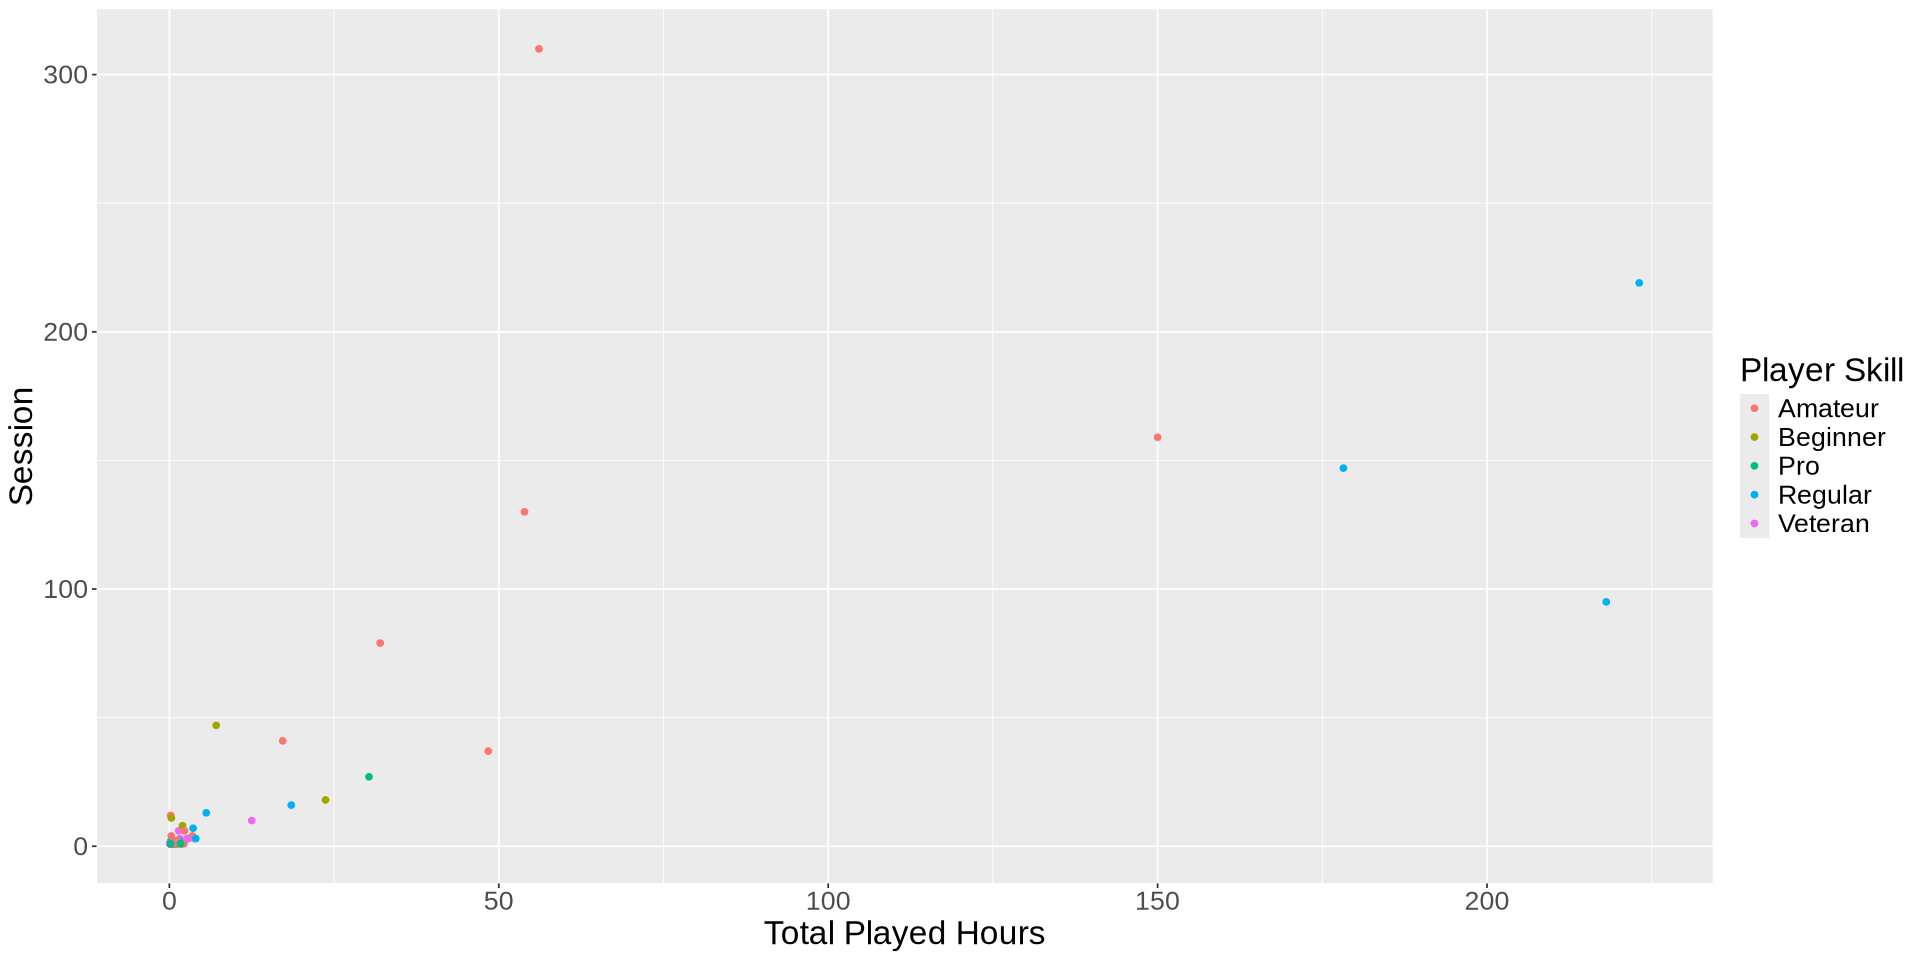

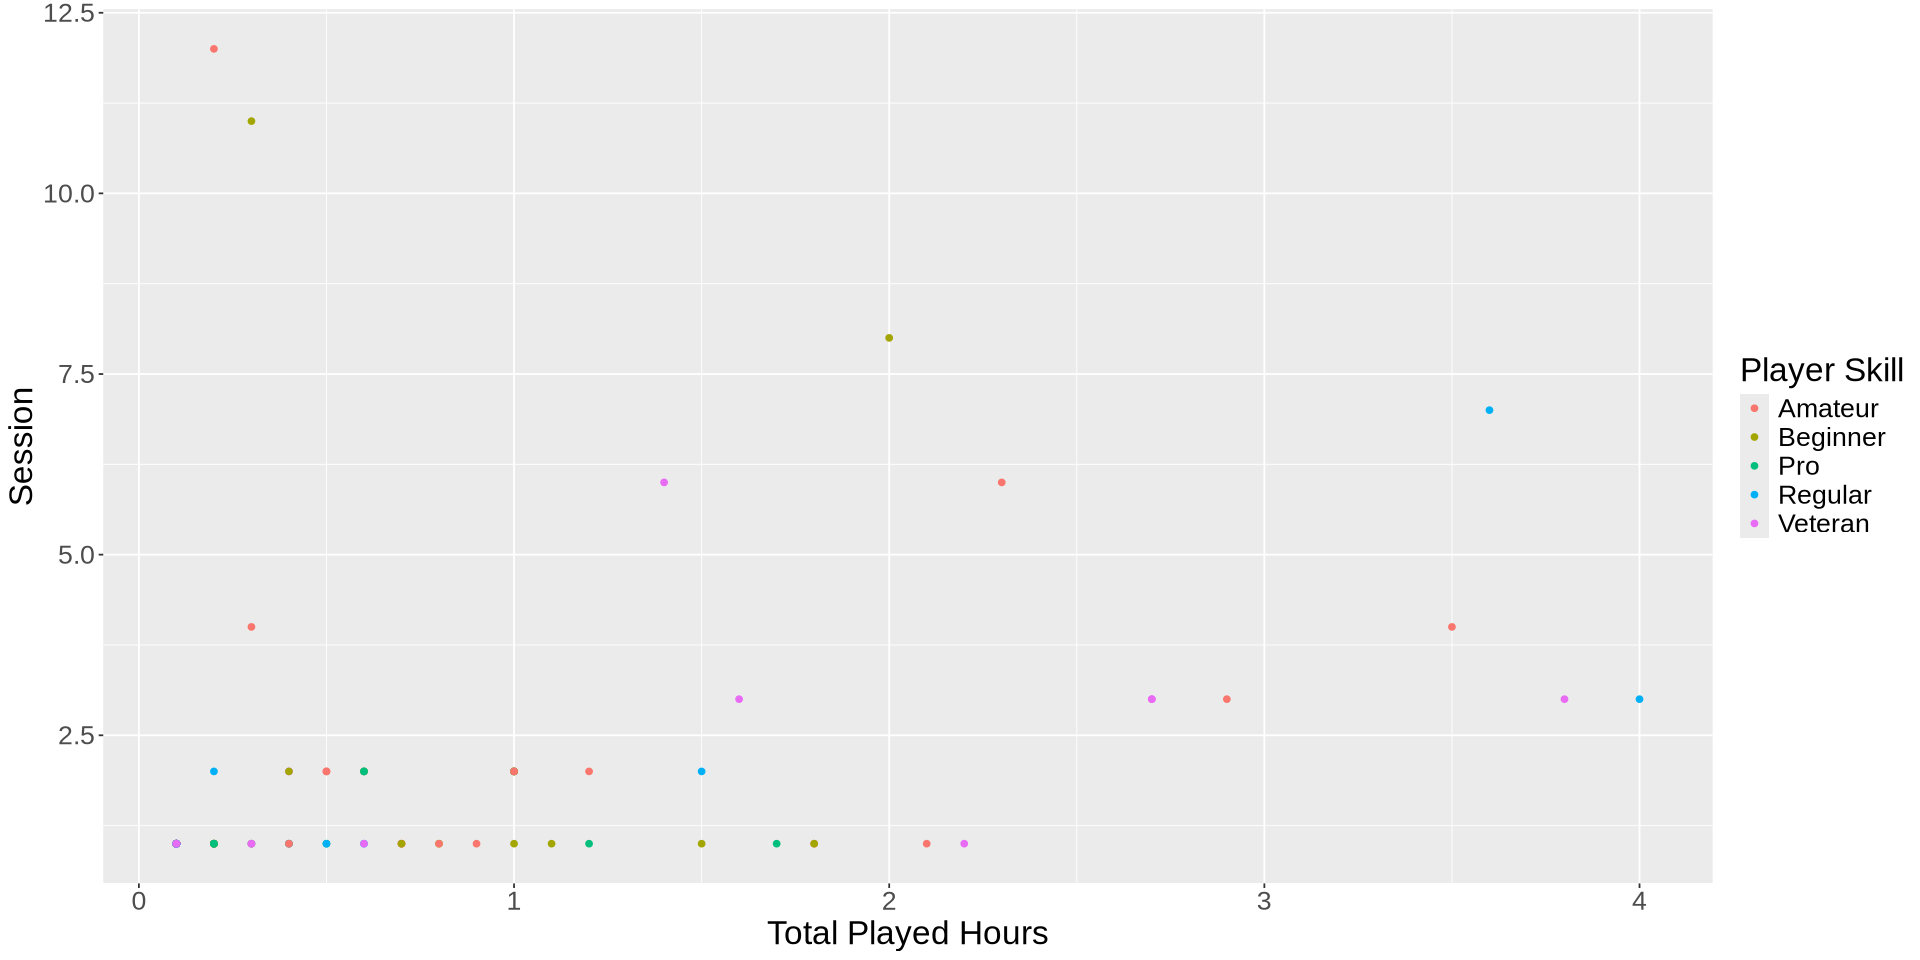

In [12]:
# Visualization ideas that may be useful
# One scatter plot with both sessions and palyed hours with expereince as color

sessions <- read_csv("https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB") 
sessions_per_player <- sessions |>
group_by(hashedEmail) |>
summarize(sessions = n()) |>
arrange(-sessions) 

no_0 <- players |>
filter(played_hours != 0)

players_combined <- left_join(no_0, sessions_per_player, by = "hashedEmail") 

options(repr.plot.width = 16, repr.plot.height = 8)
ggplot(players_combined, aes(x = played_hours, y = sessions, color = experience)) +
geom_point() +
labs(x = "Total Played Hours", y = "Session", color = "Player Skill") +
theme(text = element_text(size = 20))

players_filtered <- players_combined |>
filter(played_hours < 5) |>
filter(sessions < 50)

options(repr.plot.width = 16, repr.plot.height = 8)
ggplot(players_filtered, aes(x = played_hours, y = sessions, color = experience)) +
geom_point() +
labs(x = "Total Played Hours", y = "Session", color = "Player Skill") +
theme(text = element_text(size = 20))